In [31]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.19.0


In [32]:
# angry : angry
# happy : happy
# relaxed : relaxed
# sad : sad
    
import os
driver_image_path = r'C:\Users\U2SR\Desktop\study\ts-cnn\Dog Emotion'
class_names = sorted(os.listdir(driver_image_path))
print(class_names)

['angry', 'happy', 'relaxed', 'sad']


In [33]:
#openCV 설치
!pip install opencv-python

In [34]:
#이미지 크기 확인하기
import cv2
image = cv2.imread(r'C:\Users\U2SR\Desktop\study\ts-cnn\Dog Emotion\angry\0aNyXBrmNA7XdefwHvgO2n1rnpqQAp885.jpg')
image.shape

(400, 440, 3)

In [35]:
img_size = (200, 200)  # (width, height)

images = []
labels = []

for class_name in class_names:
    images_files_folder_name = os.path.join(driver_image_path, class_name)
    if os.path.isdir(images_files_folder_name):
        for image_name in os.listdir(images_files_folder_name):
            if image_name.endswith('.jpg'):
                image_full_path = os.path.join(images_files_folder_name, image_name)
                img = cv2.imread(image_full_path)
                img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_cvt, img_size)  # 크기 통일

                images.append(img_resized)

                label = class_names.index(class_name)
                labels.append(label)

print(f"Total images : {len(images)} , Total labels : {len(labels)}")

Total images : 3975 , Total labels : 3975


In [20]:
import numpy as np

images_np = np.array(images)
labels_np = np.array(labels)

print(images_np.shape)  # (샘플수, 200, 200, 3)
print(labels_np.shape)  # (샘플수,)

(3975, 200, 200, 3)
(3975,)


In [21]:
!pip install scikit-learn

In [22]:
# @title images , labels 리스트를 X_train 과 X_val로 분할(Train에 80%, Validation에 20% 할당)

from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(images , labels , test_size = 0.2)

In [23]:
# @title 랜덤회전 , 랜덤 수평플립, 랜덤 대비 조정 3가지 데이터 증강 적용

import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.05),             #랜덤 회전
    tf.keras.layers.RandomFlip(mode='horizontal'),           #랜덤 수평 플립
    tf.keras.layers.RandomContrast(factor=0.2),              #랜덤 대비 조정
])

In [24]:
#이미지 크기를 지정된 크기로 조정해주는 함수
def preprocessing_image(image , label):
  image = tf.image.resize(image , img_size[:2])
  return image , label

#이미지에 이미지 증강을 적용해주는 함수
def augment_image(image , label):
  image = data_augmentation(image)
  return image , label

#이미지와 레이블을 tensorflow dataset으로 변환하고, 전처리 및 증강을 적용하여 배치와 프리패칭을 설정하는 함수
def create_tensorflow_dataset(images ,labels , batch_size = 32 , buffer_size = 1000 , augment = False):
  dataset = tf.data.Dataset.from_tensor_slices((images , labels))
  dataset = dataset.map(preprocessing_image , num_parallel_calls = tf.data.AUTOTUNE)
  if augment:
    dataset = dataset.map(augment_image , num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
  return dataset

In [25]:
import tensorflow as tf

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy(resolver)
    print("TPU 연결 완료")
except ValueError:
    tpu_strategy = tf.distribute.get_strategy()  # 기본 strategy 생성
    print("TPU 없음, 기본 strategy 사용")

global_batch_size = 32 * tpu_strategy.num_replicas_in_sync
print(f"Global batch size: {global_batch_size}")

TPU 없음, 기본 strategy 사용
Global batch size: 32


In [26]:
# @title 앞서 정의한 TensorFlow Dataset 함수를 이용하여 Train_dataset 및 Val_dataset 데이터셋 생성(Train_dataset에만 데이터 증강 적용)

train_dataset = create_tensorflow_dataset(X_train , y_train , batch_size = global_batch_size , buffer_size = len(X_train) , augment = True)
val_dataset = create_tensorflow_dataset(X_val , y_val , batch_size = global_batch_size , buffer_size = len(X_val) , augment = False)

In [36]:
img_size = (200, 200, 3)

with tpu_strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=img_size),
        tf.keras.layers.Rescaling(scale=1./255),

        tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping_cb])

model.save('my_custom_cnn_model.h5')

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.3296 - loss: 1.3606 - val_accuracy: 0.3635 - val_loss: 1.2753
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.3698 - loss: 1.2864 - val_accuracy: 0.3786 - val_loss: 1.2454
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.3708 - loss: 1.2676 - val_accuracy: 0.3761 - val_loss: 1.2393
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.4192 - loss: 1.2300 - val_accuracy: 0.4151 - val_loss: 1.2113
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.4289 - loss: 1.2214 - val_accuracy: 0.4088 - val_loss: 1.2246
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.4349 - loss: 1.1920 - val_accuracy: 0.4050 - val_loss: 1.2047
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.4635 - loss: 1.1817 - val_accuracy: 0.4164 - val_loss: 1.2020
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.4585 -

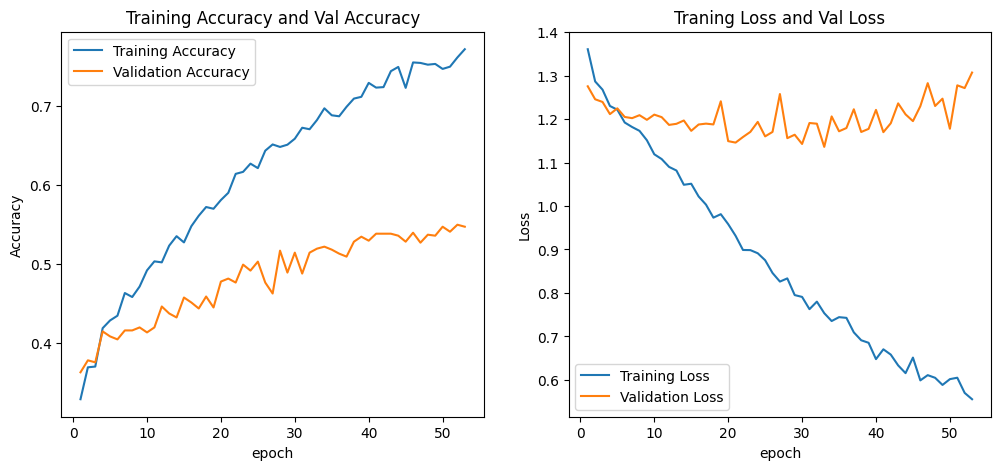

In [43]:
# @title Matplotlib를 사용하여 Accuracy 및 Loss 시각화

history = history.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epoch = range(1 , len(loss) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize  = (12 , 5))
plt.subplot(121)
plt.plot(epoch , accuracy , label = 'Training Accuracy')
plt.plot(epoch , val_accuracy , label = 'Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy and Val Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epoch , loss , label = 'Training Loss')
plt.plot(epoch , val_loss , label = 'Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Traning Loss and Val Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


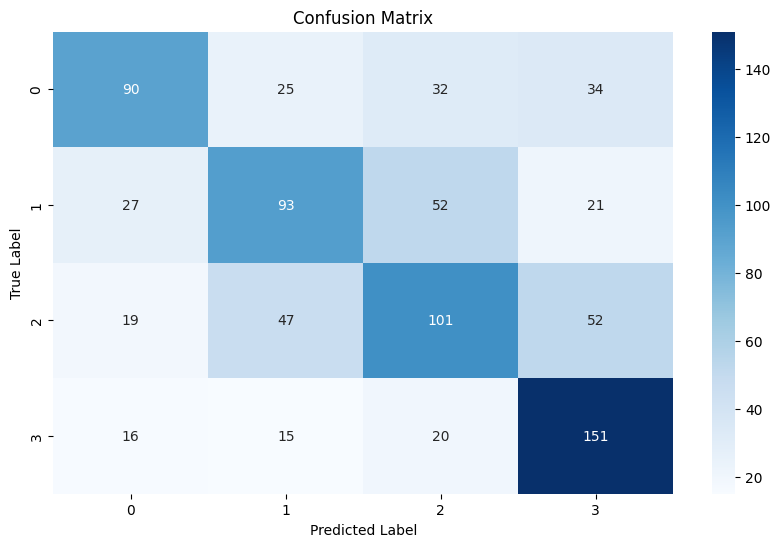

In [46]:
# @title Matplotlib를 사용하여 Confusion Matrix (혼동 행렬) 시각화

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
y_true = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10 , 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


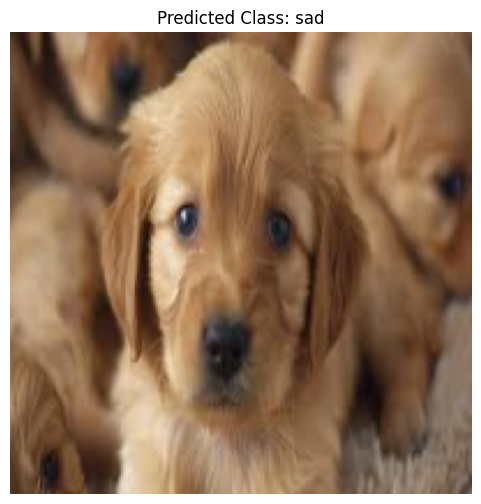

Predicted probabilities (in %): [[ 0.28458604  0.26762125 14.570586   84.8772    ]]


In [48]:
# @title 훈련한 모델로 test 파일에 있는 이미지 한개 가져와 잘 분류하는지 확인

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#테스트 이미지 경로
test_image_path = r'C:\Users\U2SR\Desktop\study\ts-cnn\sad.jpg'

#이미지 로드,전처리 함수 구현
def load_and_preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지 error인것같네요")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size[:2])
    img_array = np.asarray(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

target_size = (200, 200)
test_img_array = load_and_preprocess_image(test_image_path, target_size)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

#클래스 이름 정의
class_names = {
    0: 'angry',
    1: 'happy',
    2: 'relaxed',
    3: 'sad'
}

predicted_class_name = class_names[predicted_class]

plt.figure(figsize=(6, 6))
plt.imshow(test_img_array[0].astype('uint8'))
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()

print(f'Predicted probabilities (in %): {predictions * 100}')